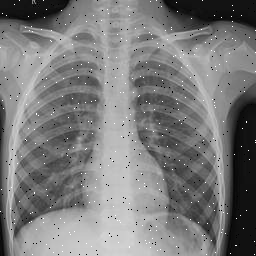

True

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.util import random_noise
import math

#Codigo para calcular as metricas de qualidade

#MSE - Mean Square Error
#Quanto mais próximo do zero, mais iguais as imagens são
def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

#PSNR - Peak Signal to Noise Error
#Medido em dB
#Quanto maior melhor (considerável bom >= 20 dB)
def psnr(original, compressed):
	mse = np.mean((original - compressed) ** 2)
	if(mse == 0): #indica que sao totalmente iguais
		return 100
	max_pixel = 255.0
	psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
	return psnr #Fixed indentation

#Funcao que cria o filtro Gaussiano
def gauss_create(sigma=1, size_x=3, size_y=3):
    '''
    Create normal (gaussian) distribuiton
    '''
    x, y = np.meshgrid(np.linspace(-1,1,size_x), np.linspace(-1,1,size_y))
    calc = 1/((2*np.pi*(sigma**2)))
    exp = np.exp(-(((x**2) + (y**2))/(2*(sigma**2))))

    return exp*calc

def add_padding(img, padding_height, padding_width):
    n, m = img.shape

    padded_img = np.zeros((n + padding_height * 2, m + padding_width * 2))
    padded_img[padding_height : n + padding_height, padding_width : m + padding_width] = img

    return padded_img

#Funcao que faz a convolucao
def conv2d(img, kernel, padding=True):
    # Get dimensions of the kernel
    k_height, k_width = kernel.shape  # Atribui valor à variável k_height, k_width

    # Get dimensions of the image
    img_height, img_width = img.shape  # Atribui valor à variável img_height, img_width

    # Calculate padding required
    pad_height = k_height // 2  # Atribui valor à variável pad_height
    pad_width = k_width // 2  # Atribui valor à variável pad_width

    # Create a padded version of the image to handle edges
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)  # Atribui valor à variável padded_img

    #print(padded_img)

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)  # Atribui valor à variável output

    # Perform convolution
    for i_img in range(img_height):  # Loop usando i
        for j_img in range(img_width):  # Loop usando j
            for i_kernel in range(k_height):
                for j_kernel in range(k_width):
                    output[i_img, j_img] = output[i_img, j_img] + (padded_img[i_img+i_kernel, j_img+j_kernel] * kernel[i_kernel, j_kernel])  # Atribui valor à variável output[i, j]
            output[i_img, j_img] = int(output[i_img, j_img])

    return np.array(output, dtype=np.uint8)

#funcao que calcula o kernel do FDA
def calc_kernel(img, t, lamb, i_img, j_img):
    kernel = np.zeros((3,3), dtype= float)
    for i in range(3):
        for j in range(3):
            if i != 1 or j != 1:
                kernel[i,j] = (1 - np.exp(-8*t*np.exp((-(np.power(abs(img[i_img+1,j_img+1] - img[i_img+i, j_img+j]), 1/5)/lamb))/5)))/8
                kernel[1,1] += kernel[i,j]
    kernel[1,1] = 1 - kernel[1,1]
    return kernel

def fda(img, t, iterations, lamb, padding=True):

    # Get dimensions of the image
    img_height, img_width = img.shape  # Atribui valor à variável img_height, img_width


    # Get dimensions of the kernel
    k_height = 3
    k_width = 3  # Atribui valor à variável k_height, k_width

    # Calculate padding required
    pad_height = k_height // 2  # Atribui valor à variável pad_height
    pad_width = k_width // 2  # Atribui valor à variável pad_width

    # Initialize an output image with zeros
    output = np.array(img, dtype=float)  # Atribui valor à variável output

    for it in range(iterations):

        # Create a padded version of the image to handle edges
        if padding == True:
            padded_img = add_padding(output, pad_height, pad_width)  # Atribui valor à variável padded_img


        output = np.zeros((img_height, img_width), dtype=float)  # Atribui valor à variável output

        for i_img in range(img_height):  # Loop usando i
            for j_img in range(img_width):  # Loop usando j

                #calculo do kernel
                kernel = calc_kernel(padded_img, t, lamb, i_img, j_img)

                for i_kernel in range(k_height):
                    for j_kernel in range(k_width):
                        output[i_img, j_img] = output[i_img, j_img] + padded_img[i_img+i_kernel, j_img+j_kernel] * kernel[i_kernel, j_kernel]  # Atribui valor à variável output[i, j]
                        if output[i_img, j_img] < 0 or output[i_img, j_img] > 255:
                          if output[i_img, j_img] < 0:
                            output[i_img, j_img] = 0
                          elif output[i_img, j_img] > 255:
                            output[i_img, j_img] = 255
                #output[i_img, j_img] = int(output[i_img, j_img])

    return np.array(output, dtype=np.float32)

#funcao que calcula a mascara para o unsharp
def mask_create(img, img_borrada):
    # Get dimensions of the image
    img_height, img_width = img.shape

    # Get dimensions of the image blurred
    img_borrada_height, img_borrada_width = img_borrada.shape

    if((img_borrada_height == img_height) and (img_borrada_width == img_width)):
        # Initialize an output image with zeros
        output = np.zeros((img_height, img_width), dtype=float)  # Atribui valor à variável output

        for i_img in range(img_height):  # Loop usando i
            for j_img in range(img_width):  # Loop usando j
                output[i_img, j_img] = img[i_img, j_img] - img_borrada[i_img, j_img]
                if(output[i_img, j_img] < 0):
                    output[i_img, j_img] = 0
                if(output[i_img, j_img] > 255):
                    output[i_img, j_img] = 255

        return np.array(output, dtype=np.float32)
    else:
        return print("As imagens devem ter o mesmo tamanho")

#funcao que faz o calculo do unsharp
def unsharp_create(img, img_mask, k):
    # Get dimensions of the image
    img_height, img_width = img.shape

    # Get dimensions of the image mask
    img_mask_height, img_mask_width = img_mask.shape

    if((img_mask_height == img_height) and (img_mask_width == img_width)):
        # Initialize an output image with zeros
        output = np.zeros((img_height, img_width), dtype=float)

        for i_img in range(img_height):  # Loop usando i
            for j_img in range(img_width):  # Loop usando j
                output[i_img, j_img] = img[i_img, j_img] + (k * img_mask[i_img, j_img])
                if(output[i_img, j_img] < 0):
                    output[i_img, j_img] = 0
                if(output[i_img, j_img] > 255):
                    output[i_img, j_img] = 255

        return np.array(output, dtype=np.float32)
    else:
        return print("As imagens devem ter o mesmo tamanho")

def conv2d_sharpening(img, kernel, padding=True):
    # Get dimensions of the kernel
    k_height, k_width = kernel.shape  # Atribui valor à variável k_height, k_width

    # Get dimensions of the image
    img_height, img_width = img.shape  # Atribui valor à variável img_height, img_width

    # Calculate padding required
    pad_height = k_height // 2  # Atribui valor à variável pad_height
    pad_width = k_width // 2  # Atribui valor à variável pad_width

    # Create a padded version of the image to handle edges
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)  # Atribui valor à variável padded_img

    #print(padded_img)

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)  # Atribui valor à variável output

    # Perform convolution
    for i_img in range(img_height):  # Loop usando i
        for j_img in range(img_width):  # Loop usando j
            #calcula kernel
            for i_kernel in range(k_height):
                for j_kernel in range(k_width):
                    output[i_img, j_img] = output[i_img, j_img] + (padded_img[i_img+i_kernel, j_img+j_kernel] * kernel[i_kernel, j_kernel])  # Atribui valor à variável output[i, j]
            output[i_img, j_img] = int(output[i_img, j_img])

    return np.array(output, dtype=np.float32)

#Abrir a imagem
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/images/chest1.png',0)

#salt and pepper noisy
noisy_image = random_noise(img, mode='s&p', amount=0.01)
noisy_image = np.array(255*noisy_image, dtype = 'float32')
#gaussian noisy
#noisy_image = random_noise(img, mode='gaussian', var=0.0009)
#noisy_image = np.array(255*noisy_image, dtype = 'uint8')
cv2_imshow(noisy_image)
cv2.imwrite('noisyImage.png', noisy_image)

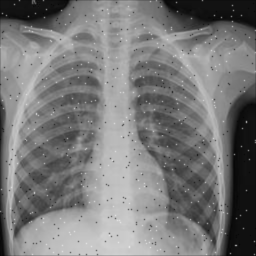

Metrica MSE(Gauss):  65.27420043945312
Metrica PSNR(Gauss):  36.88923296600797


In [8]:
#Aplicando o filtro gaussiano
gaus_3x3 = gauss_create(sigma=0.6, size_x=3, size_y=3)
img_gauss = conv2d(noisy_image, gaus_3x3)
cv2_imshow(img_gauss)
cv2.imwrite('gauss.png', img_gauss)

#Metricas de qualidade para o filtro gaussiano
metrica_mse = mse(img, img_gauss)
print("Metrica MSE(Gauss): ", metrica_mse)
metrica_psnr = psnr(img, img_gauss)
print("Metrica PSNR(Gauss): ", metrica_psnr)

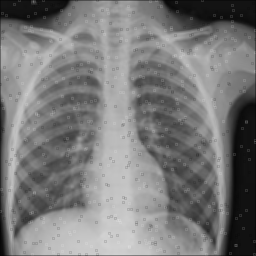

Metrica MSE(FDA):  69.24968423875576
Metrica PSNR(FDA):  29.72662544862378


In [6]:
#Aplicando o filtro FDA
img_fda = fda(noisy_image, 0.5, 1, 15)
cv2_imshow(img_fda)
cv2.imwrite('fda-0.5-1-15.png', img_fda)

#Metricas de qualidade para o FDA
metrica_mse = mse(img, img_fda)
print("Metrica MSE(FDA): ", metrica_mse)
metrica_psnr = psnr(img, img_fda)
print("Metrica PSNR(FDA): ", metrica_psnr)

Gauss com Sobel


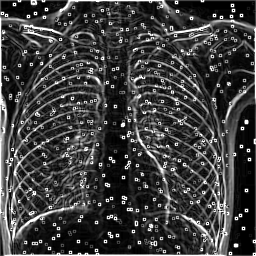

FDA com Sobel


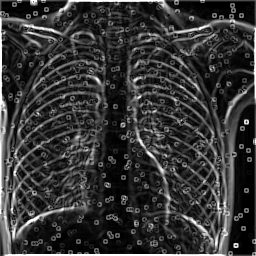

True

In [9]:
#Aplicando o sobel no FDA e Gauss, ambos SEM o Unsharp Masking e Highboost Filtering
kernel_sobel_1 = np.array(([-1,-2,-1],[0,0,0],[1,2,1]))
kernel_sobel_2 = np.array(([-1,0,1],[-2,0,2],[-1,0,1]))
#Sobel do Gauss
img_sobel_gauss_1 = conv2d_sharpening(img_gauss, kernel_sobel_1)
img_sobel_gauss_2 = conv2d_sharpening(img_gauss, kernel_sobel_2)
img_sobel_gauss = np.abs(img_sobel_gauss_1)+np.abs(img_sobel_gauss_2)
print("Gauss com Sobel")
cv2_imshow(img_sobel_gauss)
cv2.imwrite('gauss_sobel_sem_UMHB.png', img_sobel_gauss)
#Sobel do FDA
img_sobel_fda_1 = conv2d_sharpening(img_fda, kernel_sobel_1)
img_sobel_fda_2 = conv2d_sharpening(img_fda, kernel_sobel_2)
img_sobel_fda = np.abs(img_sobel_fda_1)+np.abs(img_sobel_fda_2)
print("FDA com Sobel")
cv2_imshow(img_sobel_fda)
cv2.imwrite('fda_sobel_sem_UMHB.png', img_sobel_fda)

Imagem UMHB Gauss


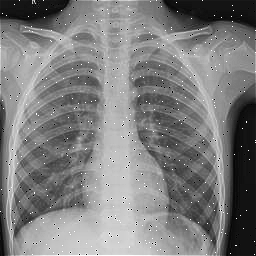

Imagem UMHB FDA


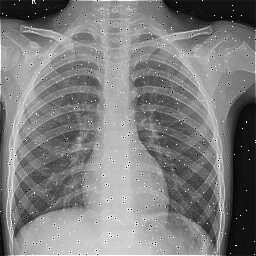

True

In [12]:
#Aplicando o Unsharp Masking e Highboost Filtering
#Usando o Gauss
#mascara
img_mask_gauss = mask_create(noisy_image, img_gauss)
# aplicacao do unsharp com k ajustado e limitação dos valores
k = 1.5
img_UMHB_gauss = unsharp_create(noisy_image, img_mask_gauss, k)
print("Imagem UMHB Gauss")
cv2_imshow(img_UMHB_gauss)
cv2.imwrite('gauss-UMHB.png', img_UMHB_gauss)
#Usando o FDA
#mascara
img_mask_fda = mask_create(noisy_image, img_fda)
# aplicacao do unsharp com k ajustado e limitação dos valores
k = 1.5
img_UMHB_fda = unsharp_create(noisy_image, img_mask_fda, k)
print("Imagem UMHB FDA")
cv2_imshow(img_UMHB_fda)
cv2.imwrite('fda-0.5-1-15-UMHB.png', img_UMHB_fda)

Sobel do Gauss UMHB


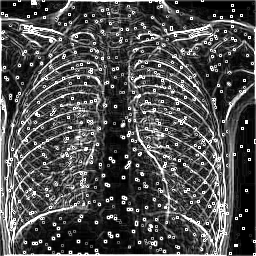

Sobel do FDA UMHB


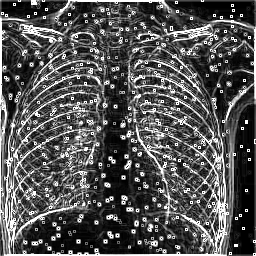

True

In [11]:
#Aplicando o sobel no FDA e Gauss, ambos COM o Unsharp Masking e Highboost Filtering
kernel_sobel_1 = np.array(([-1,-2,-1],[0,0,0],[1,2,1]))
kernel_sobel_2 = np.array(([-1,0,1],[-2,0,2],[-1,0,1]))
#Sobel do Gauss
img_sobel_gauss_UMHB_1 = conv2d_sharpening(img_UMHB_gauss, kernel_sobel_1)
img_sobel_gauss_UMHB_2 = conv2d_sharpening(img_UMHB_gauss, kernel_sobel_2)
img_sobel_gauss_UMHB = np.abs(img_sobel_gauss_UMHB_1)+np.abs(img_sobel_gauss_UMHB_2)
print("Sobel do Gauss UMHB")
cv2_imshow(img_sobel_gauss_UMHB)
cv2.imwrite('gauss_sobel_com_UMHB.png', img_sobel_gauss_UMHB)
#Sobel do FDA
img_sobel_fda_UMHB_1 = conv2d_sharpening(img_UMHB_fda, kernel_sobel_1)
img_sobel_fda_UMHB_2 = conv2d_sharpening(img_UMHB_fda, kernel_sobel_2)
img_sobel_fda_UMHB = np.abs(img_sobel_fda_UMHB_1)+np.abs(img_sobel_fda_UMHB_2)
print("Sobel do FDA UMHB")
cv2_imshow(img_sobel_fda_UMHB)
cv2.imwrite('fda_sobel_com_UMHB.png', img_sobel_fda_UMHB)

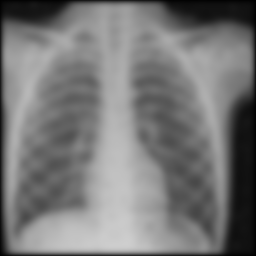

Tempo da versão original: 83.02168130874634 segundos


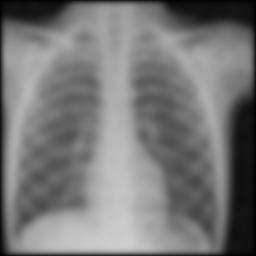

Tempo da versão com LUT: 36.73106622695923 segundos


True

In [19]:
import time
#Pontuação extra(fazendo o calculo de fda com uma LUT)
# Função para criar a LookUp Table (LUT)
def create_lut(lamb, t):
    lut = np.zeros((256, 256), dtype=float)
    for alpha in range(256):
        for beta in range(256):
            diff = abs(alpha - beta) ** (1 / 5)
            lut[alpha, beta] = (1 - np.exp(-8 * t * np.exp(-(diff / lamb) / 5))) / 8
    return lut

# Função que usa a LUT para calcular o kernel do FDA
def calc_kernel_lut(img, lut, i_img, j_img):
    kernel = np.zeros((3, 3), dtype=float)
    for i in range(3):
        for j in range(3):
            if i != 1 or j != 1:
                alpha = int(img[i_img + 1, j_img + 1])
                beta = int(img[i_img + i, j_img + j])
                kernel[i, j] = lut[alpha, beta]
                kernel[1, 1] += kernel[i, j]
    kernel[1, 1] = 1 - kernel[1, 1]
    return kernel

def fda_lut(img, t, iterations, lamb, padding=True):
    # Criação da LUT
    lut = create_lut(lamb, t)

    # Dimensões da imagem
    img_height, img_width = img.shape

    # Dimensões do kernel
    k_height = 3
    k_width = 3

    # Padding
    pad_height = k_height // 2
    pad_width = k_width // 2

    # Imagem de saída inicializada
    output = np.array(img, dtype=float)

    for it in range(iterations):
        if padding == True:
            padded_img = add_padding(output, pad_height, pad_width)

        output = np.zeros((img_height, img_width), dtype=float)

        for i_img in range(img_height):
            for j_img in range(img_width):
                # Calcular kernel usando LUT
                kernel = calc_kernel_lut(padded_img, lut, i_img, j_img)

                for i_kernel in range(k_height):
                    for j_kernel in range(k_width):
                        output[i_img, j_img] += padded_img[i_img + i_kernel, j_img + j_kernel] * kernel[i_kernel, j_kernel]
                        if output[i_img, j_img] < 0:
                            output[i_img, j_img] = 0
                        elif output[i_img, j_img] > 255:
                            output[i_img, j_img] = 255

    return np.array(output, dtype=np.float32)

# Versão original
start = time.time()
img_fda_normal = fda(noisy_image, 0.5, 20, 15)
end = time.time()
cv2_imshow(img_fda_normal)
print(f"Tempo da versão original: {end - start} segundos")
cv2.imwrite('img_fda_0.5_20_15_sem_LUT.png', img_fda_normal)

# Versão com LUT
start = time.time()
img_fda_lut = fda_lut(noisy_image, 0.5, 20, 15)
end = time.time()
cv2_imshow(img_fda_lut)
print(f"Tempo da versão com LUT: {end - start} segundos")
cv2.imwrite('img_fda_0.5_20_15_com_LUT.png', img_fda_lut)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
